# MD simulation of alkanes

In [1]:
# imports
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit
import numpy as np
import statsmodels.api as sm

# **Ethane**

## simulation initialization

In [2]:
pdb = app.PDBFile('ethane.pdb') # read in the PDB file to get the initial coordinates
forcefield = app.ForceField('ethane.gaff2.xml') # give OpenMM the force field file and add to pdb variable

In [3]:
# set up the system for md simulation
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

In [4]:
# Langevin integrator
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

In [5]:
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

## energy minimization

In [6]:
# energy minimization just moves the atoms of the molecule slightly to get to a local minimum in energy.

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100) # 100 steps of energy min.

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 4.467818224810632 kJ/mol
Potential energy after minimization is 4.389967678922688 kJ/mol


## Equilibration

In [7]:
# equilibration is to get our system to our target temperature and to get the system equilibrated and ready for our production run.

from sys import stdout # sets up what information OpenMM will report to us as the simulation runs.

print('Equilibrating...')

# asking for the potential energy, and temperature every 100 timesteps.

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, # stdout = just print the info.
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin) # sets the initial velocities of the system to a temperature equivalent of 150 K.
simulation.step(2500) # integrate for 2,500 steps to allow the system to equilibrate.

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,22.16423255065887,209.90258818605528
200,18.08595496968016,369.2617923600696
300,18.02410492467656,371.80708238971226
400,18.29053060468184,289.9462641422384
500,19.345077734083556,287.58265270381196
600,14.581644358561444,151.41329549879114
700,19.109788148235992,301.9491852475134
800,12.268974325215492,296.7431564366051
900,20.872438424376398,251.75302595040867
1000,17.02978624311153,331.0021562686573
1100,20.440799657291986,316.9922875549158
1200,23.628192199682697,234.66828735560472
1300,34.127649358694825,181.6303869050248
1400,17.37149068380757,371.13223635973713
1500,33.93401752822916,282.94912041184284
1600,11.16328406963061,345.16203650858034
1700,18.580168338275236,319.0661173897797
1800,11.321302292567271,309.08555268897396
1900,9.186946072641446,246.8771165525784
2000,19.34856988868021,215.38986154919016
2100,10.646566342350862,320.05976701388477
2200,21.14974395943004,293.99556708664306
2300,26.353

## production

In [8]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=',')) # information printed every 250,000 timesteps.

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('ethane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,26.057198063688894,211.14165875957528,0
500000,999.9999999901769,9.207478698847929,250.1132475188286,2.83e+04
750000,1499.9999999783536,13.7017360497411,164.36365871642508,2.88e+04
1000000,1999.9999999665301,20.961959993073094,188.35785612606293,2.85e+04
1250000,2499.9999999547067,17.8116695257879,228.69063522457472,2.91e+04
1500000,2999.9999999428833,12.912378647546062,184.31960711966144,2.94e+04
1750000,3499.99999993106,25.691853751318295,316.2090109231881,2.98e+04
2000000,3999.9999999192364,29.523497668761603,485.95741499237846,2.98e+04
2250000,4499.9999999992715,22.47444965259233,412.9341752675589,2.99e+04
2500000,5000.000000101135,19.5372733924846,257.29023347211785,3.01e+04
2750000,5500.000000202998,21.374925249705246,237.30163783012358,2.98e+04
3000000,6000.000000304862,18.959287528829307,422.2891085746099,2.97e+04
3250000,6500.000000406725,14.407744

# **Butane**

## simulation set-up

In [9]:
# read in a starting structure for butane and the
# corresponding force field file
pdb = app.PDBFile('butane.pdb')
forcefield = app.ForceField('butane.gaff2.xml')

# setup system by taking topology from pdb file;
# run gas phase simulation with 2 fs time step (using SHAKE)
# at 298.15 K using a Langevin thermostat (integrator) with
# coupling constant of 5.0 ps^-1
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, 
                                 constraints=app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 
                                   2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

## energy minimization

In [10]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print("Potential energy before minimization is %s" % st.getPotentialEnergy())

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print("Potential energy after minimization is %s" % st.getPotentialEnergy())

Minimizing...
Potential energy before minimization is 5.797528654036221 kJ/mol
Potential energy after minimization is 5.295784444937283 kJ/mol


## Equilibration

In [11]:
# double the number of steps in our equilibration since we want a time of 10 ps (5,000 * 2 fs = 10 picoseconds)

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 250, step=True, potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(5000)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,52.65864535634109,264.98947147120003
500,46.00604742201483,276.1142509316405
750,49.184163011345056,383.5205348272466
1000,56.20318207193844,241.36877948440772
1250,45.67186517249241,231.30217252536417
1500,37.38647124013045,261.23822009404216
1750,16.2292929265491,208.90066779319045
2000,36.18703682852887,419.89667473744225
2250,38.97359185921103,261.0967466750192
2500,36.01215578029068,285.245515788058
2750,36.957649253403254,191.39963416346524
3000,27.167209141620816,266.8115310757112
3250,41.81023591289779,160.6306032158399
3500,49.56434249714271,312.1835767189677
3750,46.871019550078,413.56789837995245
4000,34.48281850911455,530.818659037029
4250,34.80325905460149,336.72877622375967
4500,31.011500780123214,273.63554775664653
4750,46.095910916908956,250.77409876253859
5000,37.511593510711165,221.56029217168464


## production

In [12]:
print('Running Production...')

tinit=time.time()
simulation.reporters.clear()
# output basic simulation information below every 500000 steps/1 ns
simulation.reporters.append(app.StateDataReporter(stdout, 500000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))
# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps/0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run the simulation for 2.0x10^7 steps/40 ns
simulation.step(20000000)
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
500000,999.9999999901769,28.292233970721913,262.4567316409744,0
1000000,1999.9999999665301,49.48736178133383,331.1017661713697,1.55e+04
1500000,2999.9999999428833,36.095071372717555,335.8304252034456,1.55e+04
2000000,3999.9999999192364,43.02314603866043,432.5278087958597,1.56e+04
2500000,5000.000000101135,53.926337213843226,349.04276533578553,1.57e+04
3000000,6000.000000304862,55.807065884209834,277.2668096224999,1.58e+04
3500000,7000.0000005085885,42.44595901570103,441.3648019600698,1.58e+04
4000000,8000.000000712315,21.762422059736235,266.9642506895129,1.55e+04
4500000,9000.000000916041,52.794255223698464,355.32536238723145,1.53e+04
5000000,10000.000001119768,45.00085364032037,318.7110415393793,1.53e+04
5500000,11000.000001323495,45.07145196432532,246.35660538900973,1.54e+04
6000000,12000.000001527222,41.89243962627038,357.86813502407733,1.54e+04
6500000,13000.000001730948,20.157

# Analysis

In [13]:
# libraries
# nglview to visualize the trajectory
# MDTraj to analyze the trajectory.


# reads all of the atomic positions from ethane_sim.dcd 
# and keeps track of atom connectivity (topology) which was given in the PDB file.

import mdtraj as md

traj = md.load('ethane_sim.dcd', top='ethane.pdb') 

In [14]:
# visualize the trajectory using nglview. 
# Nglview has a special function show_mdtraj that we can use with our trajectory because it was in a specific format from the MDTraj library.

import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

_ColormakerRegistry()

NGLWidget(max_frame=99999)

In [15]:
# pull our bonds and atoms for analysis

atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,ETH,0,
1,2,H11,H,1,ETH,0,
2,3,H12,H,1,ETH,0,
3,4,H13,H,1,ETH,0,
4,5,C2,C,1,ETH,0,
5,6,H21,H,1,ETH,0,
6,7,H22,H,1,ETH,0,
7,8,H23,H,1,ETH,0,


In [16]:
bond_indices = [0, 4] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

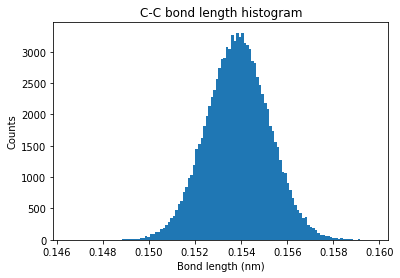

In [17]:
import matplotlib.pyplot as plt

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

### Analyzing the H-C-C-H torsion

In [18]:
# A torsion is made up of four atoms which are bonded to each other.
# Analyze the torsion angle associated with the atoms H11-C1-C2-H21 for your trajectory. 
# Instead of using the function compute_distance, use compute_dihedrals. 
# Create a histogram plot of the torsion angles. 

# pick the atom indices of our torsion angle and use the compute_dihedrals function to calculate the dihedrals.
phi_indices = [1, 0, 4, 5] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

print(phi)

[[ 1.1716627]
 [ 0.9579757]
 [ 1.1940376]
 ...
 [-1.0366436]
 [-1.2779131]
 [-1.1241577]]


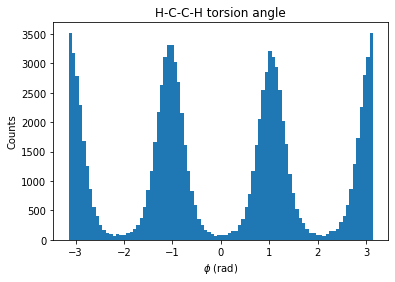

In [19]:
import matplotlib.pyplot as plt

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('H-C-C-H torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

## potential of mean force calculation

#### mean force calculation
$$ W(x) = -k_bT*ln[p(x)]+C $$

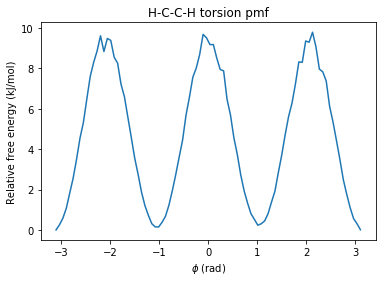

In [20]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

When we examine the plot, we can see that the PMF is not smooth near the free energy maxima. This is due to finite sampling in our relatively short simulation. This makes sense because the configurations of the molecule with the higher energy would not occur as many times during the simulation. To make this smoother, we could run a longer simulation or use a smoothing function on our data.

In [ ]:
# C-C PMF
bondcounts[bondcounts==0] = 0.1
pmf = -kB*Temp*np.log(bondcounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2

pmf_smoothed = sm.nonparametric.lowess(pmf, bincenters, frac=0.05)
pmf_s = pmf_smoothed[:,1] - np.min(pmf_smoothed[:,1])

plt.plot(bincenters, pmf_s)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-C bond length pmf')
plt.show()

In [ ]:
# higher energy bond lengths are less smooth. 
# This is because these bond lengths did not occur very much in our simulation (because of the high energy), so our statistics are poor. 
# If we wanted to exclude these areas, we could subset the part of our data which we plot:
plt.plot(bincenters[pmf_s < 15], pmf_s[pmf_s < 15])
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-C bond length pmf')
plt.show()

## **Analysis of Butane Trajectory**

### read in the md trajectory

In [23]:
traj = md.load('butane_sim.dcd', top='butane.pdb')
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


### visualize

In [24]:
visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=199999)

### Analyzing the C-C-C-C torsion

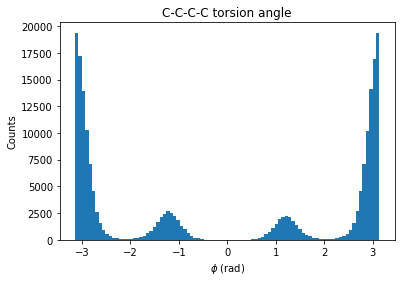

200000.0


In [25]:
phi_indices = [0, 4, 7, 10] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('C-C-C-C torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

print(np.sum(phicounts))

### C-C-C-C torsion PMF

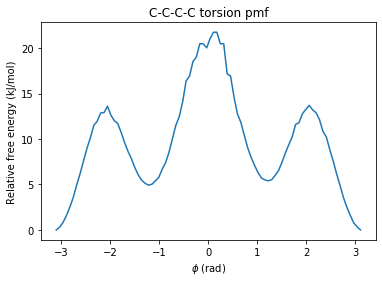

In [26]:
B = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature in K
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C-C-C-C torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

### Analyzing the C-C-C angle

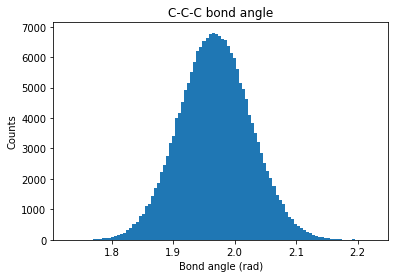

In [27]:
angle_indices = [0, 4, 7] # or could do [4, 7, 10]
bondangle = md.compute_angles(traj, [angle_indices])

anglecounts, binedges, otherstuff = plt.hist(bondangle, bins=100)
plt.title('C-C-C bond angle')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

### C-C-C angle PMF

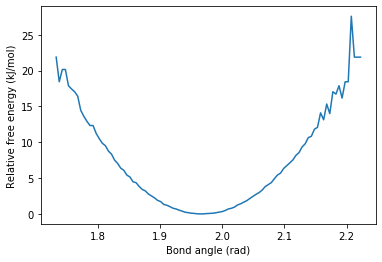

In [28]:
anglecounts[anglecounts==0] = 0.1
pmf = -kB*Temp*np.log(anglecounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2


plt.plot(bincenters, pmf)
plt.xlabel('Bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

### Analyzing a C-H bond

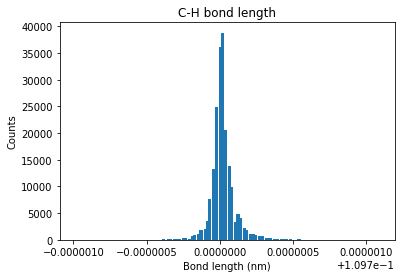

In [29]:
bond_indices = [0, 1] # many possibilities!
bondlength = md.compute_distances(traj, [bond_indices])

lengthcounts, binedges, otherstuff = plt.hist(bondlength, bins=100)
plt.title('C-H bond length')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

The C-H bond length does not behave at all like something subject to a harmonic potential. So what’s going on? Remember that in this simulation we have “frozen” all of the covalent bonds involving H atoms so that we can use a 2 fs time step. Therefore only the non-H atoms undergo true dynamics; the positions of the H atoms are calculated after each time step using an interative algorithm (SHAKE).